In [54]:
%pylab inline
import requests, zipfile
import StringIO
import datetime
import pandas as pd
import numpy as np
from workflow.data import *
import matplotlib.pyplot as plt
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [55]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
plt.tight_layout

<function matplotlib.pyplot.tight_layout>

In [56]:
username = 'psam071'
host = 'localhost'
dbname = 'citibike'

db = create_engine('postgres://%s@%s/%s' % (username,host,dbname))
con = None

con = psycopg2.connect(database = dbname, user = username, host = host)

In [21]:
query = """
        SELECT * FROM stations
        WHERE long > -74.025;
"""

df = pd.read_sql_query(query, con)
df.head()

,id,docks,lat,long,name
0,72,39,40.767272,-73.993929,W 52 St & 11 Ave
1,79,33,40.719116,-74.006667,Franklin St & W Broadway
2,82,27,40.711174,-74.000165,St James Pl & Pearl St
3,83,62,40.683826,-73.976323,Atlantic Ave & Fort Greene Pl
4,116,39,40.741776,-74.001497,W 17 St & 8 Ave


In [22]:
neighborhoods = pd.read_csv('nyc_neighborhoods.csv')
neighborhoods.head()

,Borough,neighborhood,longitude,latitude
0,Bronx,Wakefield,-73.847201,40.894705
1,Bronx,Co-op City,-73.829939,40.874294
2,Bronx,Eastchester,-73.827806,40.887556
3,Bronx,Fieldston,-73.905643,40.895437
4,Bronx,Riverdale,-73.912585,40.890834


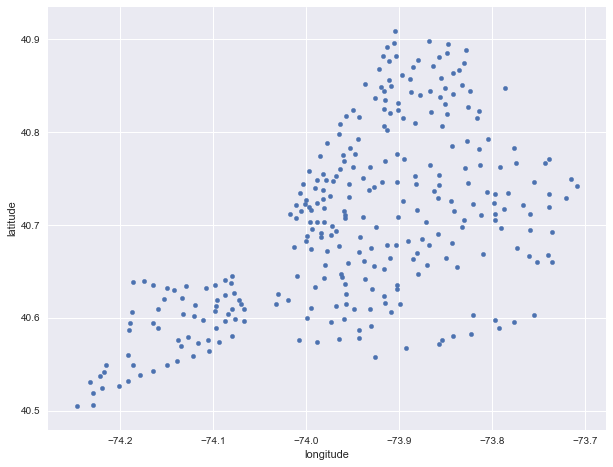

In [23]:
neighborhoods.plot.scatter(x = 'longitude', y = 'latitude', figsize = (10,8))
plt.axes().set_aspect('equal')

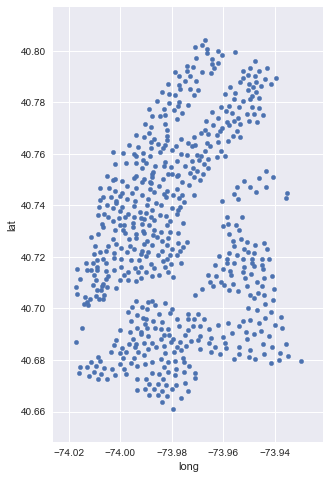

In [24]:
df.plot.scatter(x = 'long', y = 'lat', figsize = (10,8))
plt.axes().set_aspect('equal')

In [36]:
hoods = neighborhoods

In [37]:
# find the centroids in hoods that are closest to the station points in df
X = df[['long', 'lat']]

def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    deltas = nodes - node
    dist_2 = np.einsum('ij,ij->i', deltas, deltas)
    return np.argmin(dist_2)

a = hoods[['longitude', 'latitude']]
node_labels = []
# return a list of indices of hoods to pass on hoods
for i in xrange(X.shape[0]):
    node_labels.append(closest_node([X.iloc[i,:]], a))

In [38]:
df['neighborhood'] = hoods.iloc[node_labels].reset_index().neighborhood
df['borough'] = hoods.iloc[node_labels].reset_index().Borough

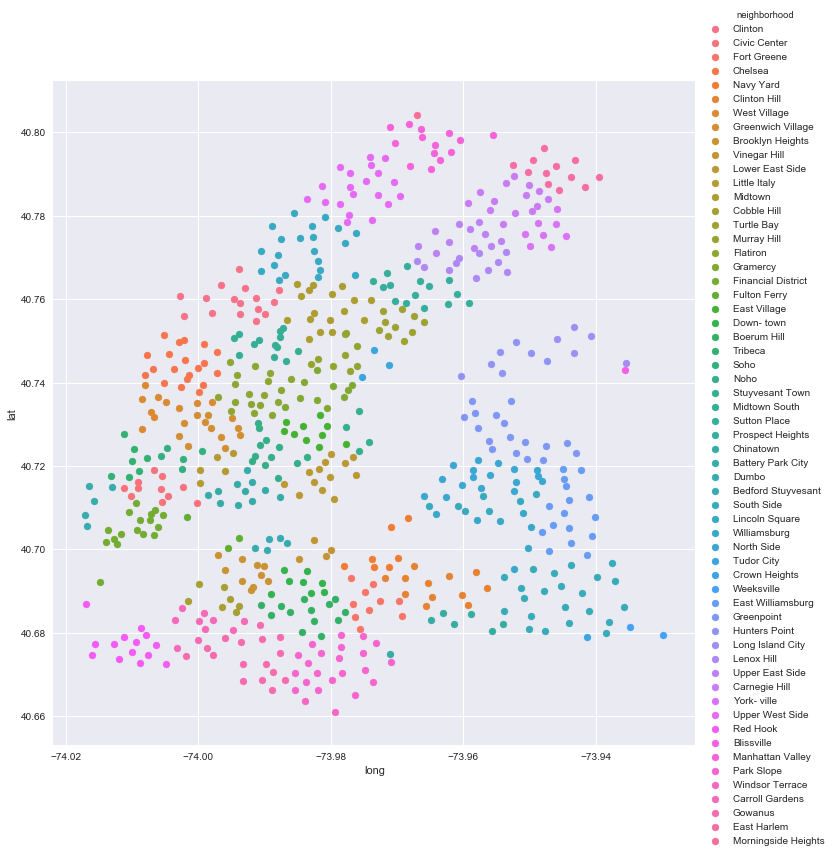

In [44]:
fg = sns.FacetGrid(data = df, hue = 'neighborhood', aspect = 1, size = 10)
fg.map(scatter, 'long', 'lat').add_legend()

In [45]:
df.head()

,id,docks,lat,long,name,neighborhood,borough
0,72,39,40.767272,-73.993929,W 52 St & 11 Ave,Clinton,Manhattan
1,79,33,40.719116,-74.006667,Franklin St & W Broadway,Civic Center,Manhattan
2,82,27,40.711174,-74.000165,St James Pl & Pearl St,Civic Center,Manhattan
3,83,62,40.683826,-73.976323,Atlantic Ave & Fort Greene Pl,Fort Greene,Brooklyn
4,116,39,40.741776,-74.001497,W 17 St & 8 Ave,Chelsea,Manhattan


In [49]:
n_hoods = df[['id', 'neighborhood', 'borough']]
n_hoods = n_hoods.set_index('id')
n_hoods.head()

,neighborhood,borough
id,,
72,Clinton,Manhattan
79,Civic Center,Manhattan
82,Civic Center,Manhattan
83,Fort Greene,Brooklyn
116,Chelsea,Manhattan


In [57]:
n_hoods.to_sql('neighborhoods', db)